![](../JFM-notebooks-logo.jpg)

In [1]:
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

# Aesthetics
sns.set_theme()
sns.set_style('ticks')
sns.set_context('paper')
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='serif')

### Define consistent colours and line styles for variations in $Re$, $Gr$, and $Pr$

In [2]:
camp = sns.color_palette('flare', as_cmap=True)
cspeed = cmocean.tools.crop_by_percent(cmocean.cm.tempo, 30, which='both', N=None)

def Re_col(lR):
    return camp((lR - 2.5)/1.5)

def Gr_col(lG):
    return cspeed((lG - 6)/2)

def Pr_stl(Pr):
    if Pr==1:
        stl = '-'
    elif Pr==4:
        stl = '--'
    elif Pr==10:
        stl = ':'
    else:
        stl = '-.'
    return stl

### Average profiles using symmetry or anti-symmetry across the midplane

In [3]:
def sym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] + v[-1:-n//2-1:-1])

def asym_prof(v):
    n = v.size
    return 0.5*(v[:n//2] - v[-1:-n//2-1:-1])

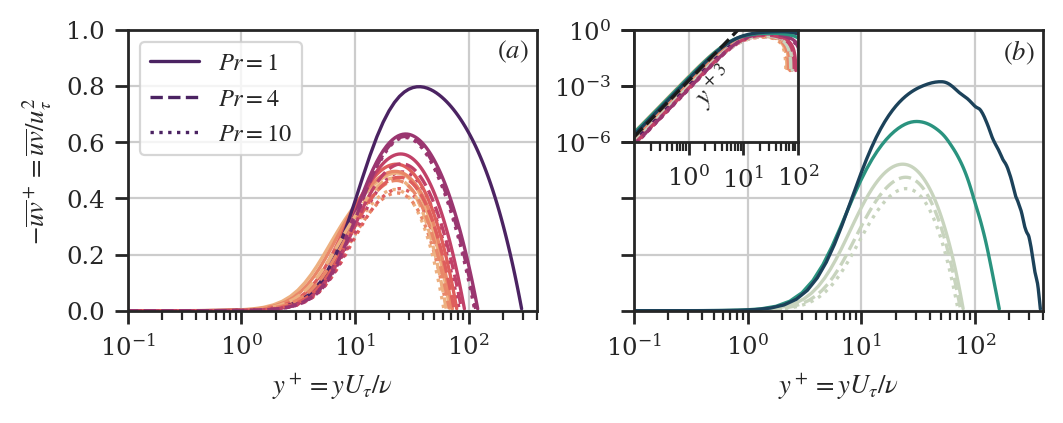

In [4]:
fig, axs = plt.subplots(1,2, figsize=(5.2,2.0), layout='constrained', dpi=200, sharex='col', sharey=True)

axin = axs[1].inset_axes([0.0,0.6,0.4,0.4])

with h5py.File('../data/profile_record.h5','r') as fp:

    for grp in fp.__iter__():
        # Read mean profile
        x = fp[grp+'/xm'][:]
        xs = x[:x.size//2]
        vybar = asym_prof(fp[grp+'/vybar'][:])
        vzbar = sym_prof(fp[grp+'/vzbar'][:])
        vxvz = asym_prof(fp[grp+'/vxvz'][:])

        # Read control parameters (logarithms)
        lGr = int(grp[2])
        lRe = float(grp[-4:])
        lRi = lGr - 2*lRe

        # Exclude cases with no pressure gradient
        if lRe > 0:
            # Compute free-fall and bulk velocity scales
            Uf = 10**np.min([lGr/2 - lRe, 0])
            Ub = 10**np.min([lRe - lGr/2, 0])
    
            Gr = 10**lGr
            Re = 10**lRe
            Pr = int(grp[6:-7])
            Ri = Gr/Re**2

            # Compute dimensionless friction velocity/shear Reynolds number (both components)
            Wtau = (vzbar[0]/x[0] / np.max([Gr**0.5,Re]) )**0.5
            Retauz2 = Wtau*np.max([Gr**0.5,Re])
            Vtau = (np.abs(vybar[0])/x[0] / np.max([Gr**0.5,Re]) )**0.5
            Retauy2 = Vtau*np.max([Gr**0.5,Re])
            Utau = (Wtau**4 + Vtau**4)**0.25
            Retau2 = (Retauz2**4 + Retauy2**4)**0.25

            # Gr=10^6 cases
            if 'Gr6' in grp:
                axs[0].plot(xs*Retau2, -vxvz/Wtau**2, color=Re_col(lRe), linestyle=Pr_stl(Pr))
                axin.plot(xs*Retau2, -vxvz/Wtau**2, color=Re_col(lRe), linestyle=Pr_stl(Pr))
            # Re=10^3 cases
            if lRe==3:
                axs[1].plot(xs*Retau2, -vxvz/Wtau**2, color=Gr_col(lGr), linestyle=Pr_stl(Pr))
                axin.plot(xs*Retau2, -vxvz/Wtau**2, color=Gr_col(lGr), linestyle=Pr_stl(Pr))

# Add legend
ax = axs[0]
Prs = [1, 4, 10]
for P in Prs:
    ax.plot(0,0, color=Re_col(4), linestyle=Pr_stl(P), label='$Pr=%i$' % P)
ax.legend()

for ax in axs:
    ax.semilogx()

axs[0].set_ylabel(r'$-\overline{u v}^+ = \overline{uv}/u_\tau^2$')
for ax in axs:
    ax.set(
        xlabel='$y^+ = y U_\\tau / \\nu$',
        ylim=[0,1],
        xlim=[1e-1,4e2]
    )
    ax.grid(True)

lbls = ['$(a)$','$(b)$']
for i, lbl in enumerate(lbls):
    axs[i].annotate(lbl, (0.98, 0.97), xycoords='axes fraction', ha='right', va='top')

axin.loglog()
# Add theoretical comparison to inset plot
xl = 10**np.linspace(-1,2,101)
axin.plot(xl, (xl/8)**3, 'k--')
axin.set_xlim([1e-1,1e2])
axin.set_ylim([1e-6,1])
axin.set_xticks([1e0,1e1,1e2])
axin.annotate('${y^+}^3$', (3,1e-3), rotation=45, ha='center', va='center')
axin.grid(True)

# fig.savefig('uv_profiles_total_yplus.pdf')

plt.show()